In [2]:
from langgraph.graph import StateGraph, START, END
import random
from typing import Dict, List, TypedDict

In [12]:
class AgentState(TypedDict):
  name: str
  numbers: List[int]
  count: int

In [13]:
def greeting_node(state: AgentState) -> AgentState:
  """This node prints a greeting message to the console."""
  print(f"Hello {state['name']}")
  state['count'] = 0
  return state

def random_node(state: AgentState) -> AgentState:
  """This node generates a random number and adds it to the numbers list."""
  state['numbers'].append(random.randint(1, 100))
  state['count'] += 1
  return state

def should_loop(state: AgentState) -> AgentState:
  """This node checks if we should loop again."""
  if state['count'] < 5:
    return 'loop'
  else:
    return "exit"
  

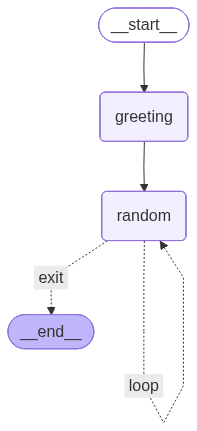

Hello John
{'name': 'John', 'numbers': [24, 11, 74, 76, 20], 'count': 5}


In [15]:
graph = StateGraph(AgentState)
graph.add_node("greeting", greeting_node)
graph.add_node("random", random_node)
graph.add_edge(START, "greeting")
graph.add_edge("greeting", "random")
graph.add_conditional_edges("random", should_loop, {
  "loop": "random",
  "exit": END
})

app = graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))
initial_state = AgentState(name="John", numbers=[], count=0)
results = app.invoke(initial_state)
print(results)


In [23]:
from typing import Optional
class AgentState(TypedDict):
  player_name: str 
  guesses: Optional[List[int]]
  target_number: Optional[int]
  hint: Optional[str]
  attempts: Optional[int]
  lower_bound: int
  upper_bound: int

In [40]:
def setup_game(state: AgentState) -> AgentState:
  """This node sets up the game by generating a random target number and initializing the game state."""
  state['target_number'] = random.randint(state["lower_bound"], state["upper_bound"])
  state["guesses"] = []
  state['attempts'] = 0
  print(f"Welcome to the game, {state['player_name']}! Try to guess the number between {state['lower_bound']} and {state['upper_bound']}.")
  return state

def guess_node(state: AgentState) -> AgentState:
  """This node represents the graph's guess"""

  state['attempts'] += 1
  possible_guesses = [i for i in range(state["lower_bound"], state["upper_bound"] + 1) if i not in state["guesses"]]
  if not possible_guesses:
    state["hint"] = "No more guesses are available."
    return state
  guess = random.choice(possible_guesses)
  state["guesses"].append(guess)
  return state

def hint_node(state: AgentState) -> AgentState:
  """This node provides a hint based on the player's guess."""
  latest_guess = state["guesses"][-1]
  print(f"latest_guess: {latest_guess}")
  print(f"You are on attempt number {state['attempts']}")
  if latest_guess < state["target_number"]:
    state["hint"] = "Try a higher number."
    print(state["hint"])
    state["lower_bound"] = max(state["lower_bound"], latest_guess)
  elif latest_guess > state["target_number"]:
    state["hint"] = "Try a lower number."
    print(state["hint"])
    state["upper_bound"] = min(state["upper_bound"], latest_guess)
  else:
    state["hint"] = "Congratulations! You guessed the number."
    print(state["hint"])
  return state

def should_continue(state: AgentState) -> AgentState:
  """This node checks if the game should continue."""
  if state["attempts"] < 7:
    return "guess"
  else:
    return "end"




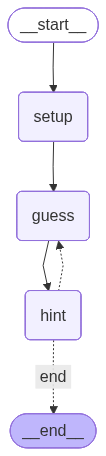

In [41]:
graph = StateGraph(AgentState)
graph.add_node("setup", setup_game)
graph.add_node("guess", guess_node)
graph.add_node("hint", hint_node)
graph.add_edge(START, "setup")
graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint")
graph.add_conditional_edges("hint", should_continue, {
  "guess": "guess",
  "end": END
})
app = graph.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))



In [43]:
app.invoke({"player_name": "Nico", "lower_bound": 1, "upper_bound": 20})

Welcome to the game, Nico! Try to guess the number between 1 and 20.
latest_guess: 3
You are on attempt number 1
Try a higher number.
latest_guess: 7
You are on attempt number 2
Try a higher number.
latest_guess: 17
You are on attempt number 3
Try a higher number.
latest_guess: 19
You are on attempt number 4
Congratulations! You guessed the number.
latest_guess: 20
You are on attempt number 5
Try a lower number.
latest_guess: 18
You are on attempt number 6
Try a higher number.
latest_guess: 18
You are on attempt number 7
Try a higher number.


{'player_name': 'Nico',
 'guesses': [3, 7, 17, 19, 20, 18],
 'target_number': 19,
 'hint': 'Try a higher number.',
 'attempts': 7,
 'lower_bound': 18,
 'upper_bound': 20}